**Predicting the best players by strength of players for playing positions**

**The Problem:** The client, a famous European Football Club wants to have a list of players to consider during transfer season. In case they need to make a transfer, they will bring in a replacement. A major part of player selection depends upon which position the player will play at. Depending on the need of the team, the managers will consider the up and coming players who will suit their need. The client requires us to build an algorithm that will predict the best 20 players for each specific position

**The Solution:** 

**Data:** The data we will use for this problem is sourced from several websites such as 

http://football-data.mx-api.enetscores.com/ : scores, lineup, team formation and events

http://www.football-data.co.uk/ : betting odds

http://sofifa.com/ : players and teams attributes from EA Sports FIFA games. FIFA series and all FIFA assets property of EA Sports;
by Hugomathien and made available on Kaggle at https://www.kaggle.com/hugomathien/soccer

**Cleaning:** 
1. From the available database, we use the tables 'players' and 'player_attributes' and identify each players preferred position of playing using their X, Y playing coordinates. We create a table of player_positions to make merging of datasets easier
2. After merging all the available datasets, we keep only the features we need to predict the performance for a player. We use the feature 'overall_rating' given by FIFA and we calculate the age of each player for the same rating date. This is to understand whether age of the player has impact on player performance. Alternatively, we can also collect rating for each player on the latest date available for the player and use that to correlate age and overall_rating
3. We check this data for missing and incorrect values and clean it

**Descriptive Analytics:**
1. Test the correlation of age with overall rating and fit a model to predict rating for each player position
2. Also test additional data from player attributes dataset like player strength, height, weight etc. to check for correlation with score (overall_rating)

**Modeling:**
1. Modify the data so that each player has aggregated rating, attributes for each age of the player. Remove the last age row of each player as testing data.
2. With the remaining data as training dataset, use these aggregated attributes to predict the aggregated overall rating of the player.
3. Transform the data if necessary such that assumptions for different models are fulfilled. Fit regression models such as linear or polynomial regression, ridge regression, SVR and find the best fitting model with best parameters.
4. Use the best model to find the predicted scores from the test dataset.
5. Use these predicted scores to identify top 10 players in each position

Step 1: Importing the data and packages required

In [2]:
#import packages
import os
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
#formatting for table displays
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

Import the data

In [4]:
#connection to database
with sqlite3.connect('/Users/ruhama.ahale/Documents/git_repository/capstone-project big files/database_with_player_positions.sqlite') as con:
    #countries = pd.read_sql_query("SELECT * from Country", con)
    #matches = pd.read_sql_query("SELECT * from Match", con)
    #leagues = pd.read_sql_query("SELECT * from League", con)
    #teams = pd.read_sql_query("SELECT * from Team", con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
    player_positions = pd.read_sql_query("SELECT * from Player_Positions", con)
    player = pd.read_sql_query("SELECT * from Player", con)

Step 2: Joining selected table to create final data table

In [5]:
player.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


In [143]:
player_attributes.head(3)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0


In [144]:
player_positions.head(3)

,player_api_id,player_name,matches_played,matches_played_in_position,preferred_x_position,preferred_y_position,player_position
0,505942,Aaron Appindangoye,8,8,6,3,Center Back
1,155782,Aaron Cresswell,75,75,8,3,Left Back
2,162549,Aaron Doran,104,78,2,7,Right Winger


Merge all the necessary files to get the final data file

In [6]:
#merge all player files to get the player details required
player_positions = player_positions[['player_api_id', 'player_name', 'player_position']]
player_attributes_new = player_attributes
player_attributes_new = player_positions.merge(player_attributes_new,on='player_api_id')
player = player[['player_api_id', 'birthday', 'height', 'weight']]
player_attributes_new = player_attributes_new.merge(player,on='player_api_id')
player_attributes_new['birthday_date'] = pd.to_datetime(player_attributes_new['birthday'])
player_attributes_new['date'] = pd.to_datetime(player_attributes_new['date'])
player_attributes_new['age'] = player_attributes_new['date'] - player_attributes_new['birthday_date']
player_attributes_new['age'] = player_attributes_new['age'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
player_attributes_new['age'] = round(player_attributes_new['age']/365,0)
player_attributes_new = player_attributes_new[player_attributes_new.date >= '2009-07-31']#taking data only from 09-10 season onwards as data prior to that is not consistent


In [5]:
player_attributes_new.head(3)

,player_api_id,player_name,player_position,id,player_fifa_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,...,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,birthday,height,weight,birthday_date,age
0,505942,Aaron Appindangoye,Center Back,1,218353,2016-02-18,67.0,71.0,right,medium,...,6.0,11.0,10.0,8.0,8.0,1992-02-29 00:00:00,182.88,187,1992-02-29,24.0
1,505942,Aaron Appindangoye,Center Back,2,218353,2015-11-19,67.0,71.0,right,medium,...,6.0,11.0,10.0,8.0,8.0,1992-02-29 00:00:00,182.88,187,1992-02-29,24.0
2,505942,Aaron Appindangoye,Center Back,3,218353,2015-09-21,62.0,66.0,right,medium,...,6.0,11.0,10.0,8.0,8.0,1992-02-29 00:00:00,182.88,187,1992-02-29,24.0


Rearrange columns as required

In [146]:
player_attributes_new = player_attributes_new[['player_api_id',  'player_name',  'player_position',   'date',  'birthday_date', 'potential', 'overall_rating',  'age', 'finishing',  'heading_accuracy',  'short_passing',  'volleys',  'dribbling',  'curve',  'free_kick_accuracy',  'long_passing',  'ball_control',  'acceleration',  'sprint_speed',  'agility',  'reactions',  'balance',  'shot_power',  'jumping',  'stamina',  'strength',  'long_shots',  'aggression',  'interceptions',  'positioning',  'vision',  'penalties',  'marking',  'standing_tackle',  'sliding_tackle',  'gk_diving',  'gk_handling',  'gk_kicking',  'gk_positioning',  'gk_reflexes',   'height',  'weight']]

player_attributes_new.head()

,player_api_id,player_name,player_position,date,birthday_date,potential,overall_rating,age,finishing,heading_accuracy,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight
0,505942,Aaron Appindangoye,Center Back,2016-02-18,1992-02-29,71.0,67.0,24.0,44.0,71.0,...,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,182.88,187
1,505942,Aaron Appindangoye,Center Back,2015-11-19,1992-02-29,71.0,67.0,24.0,44.0,71.0,...,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0,182.88,187
2,505942,Aaron Appindangoye,Center Back,2015-09-21,1992-02-29,66.0,62.0,24.0,44.0,71.0,...,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0,182.88,187
3,505942,Aaron Appindangoye,Center Back,2015-03-20,1992-02-29,65.0,61.0,23.0,43.0,70.0,...,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0,182.88,187
5,155782,Aaron Cresswell,Left Back,2016-04-21,1989-12-15,76.0,74.0,26.0,53.0,58.0,...,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,170.18,146


In [7]:
#number of unique player in our new database
player_attributes_new.player_api_id.nunique()

10867

In [7]:
#save data to csv
#df = pd.DataFrame(player_attributes_new)
#df.to_csv('player_attributes_new2.csv', sep=',', encoding='utf-8')

Check for and substitute or remove missing values

In [8]:
#missing values delete
player_attributes_new[player_attributes_new.columns[:]].isnull().sum()
player_attributes_new.isnull().any(axis=1).sum()
#find proportion of missing values
prop_missing = round((player_attributes_new[player_attributes_new.columns[:]].isnull().sum()/player_attributes_new[player_attributes_new.columns[:]].count())*100,2)
prop_missing
player_attributes_new = player_attributes_new.dropna(axis=0, how='any')
player_attributes_new.isnull().any(axis=1).sum()

0

As the proportion of missing values is small, we will remove them

In [9]:
#count unique players in each position
player_attributes_new.groupby(player_attributes_new.player_position).player_api_id.nunique()

player_position
Attacking Midfielder    1001
Center Back             1713
Center Forward          1612
Central Midfielder      1700
Goalkeeper               919
Left Back                867
Left Forward             215
Left Midfielder          278
Left Winger              344
RIght Midfielder         327
Right Back               956
Right Forward            226
Right Winger             424
Name: player_api_id, dtype: int64

Select a position to analyze

In [10]:
#select data for one position for analysis
left_back = player_attributes_new[(player_attributes_new.player_position== 'Left Back')]
df = left_back

Aggregate data by player id and age for each player, get mean of all features

In [28]:
#For all players average the data for each age
avg_age = df.groupby([ 'player_api_id', 'player_name', 'player_position',  'age'],as_index=False, sort=False).mean()
avg_age = pd.DataFrame(avg_age)
avg_age.head(2)

,player_api_id,player_name,player_position,age,potential,overall_rating,finishing,heading_accuracy,short_passing,volleys,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight
0,155782,Aaron Cresswell,Left Back,26.0,76.125,73.375,51.625,57.25,70.25,30.75,...,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0,170.18,146
1,155782,Aaron Cresswell,Left Back,25.0,76.500,70.750,50.000,54.75,68.50,28.00,...,73.0,72.0,72.0,13.0,6.0,8.0,8.0,11.0,170.18,146


In [42]:
len(avg_age)
#Get approx 80% of the data as training and 20% as test

0.20106679035250463

Seperate the test and training datasets

In [37]:
#get the max age data out as test data - seperate
max_age = avg_age.groupby(['player_api_id'], sort=False).age.max()
max_age = pd.DataFrame(max_age.reset_index(name = "age"))
#merge this max data with the rest of the df to get all other metrics
#Merge
keys = ['player_api_id','age']
i1 = avg_age.set_index(keys).index
i2 = max_age.set_index(keys).index
test_df = avg_age[i1.isin(i2)]
test_df.head(2)
len(test_df)

867

In [44]:
#merge this max data with the rest of the df to get all other metrics and remove max date obs to get training data
#Merge
keys = ['player_api_id','age']
i1 = avg_age.set_index(keys).index
i2 = max_age.set_index(keys).index
train_df = avg_age[~(i1.isin(i2))]
train_df.head(2)
len(train_df)

3445

Plot age of player and average overall rating in a scatter plot using training data

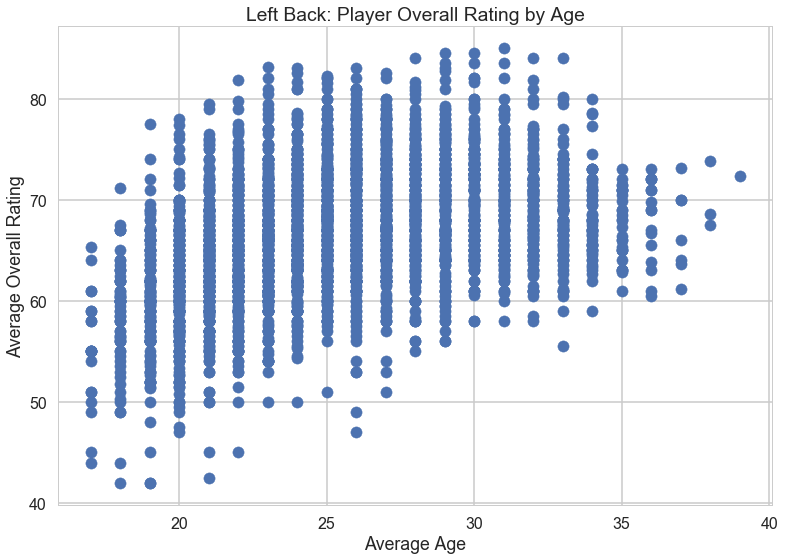

In [52]:
#Scatter plot to check relationship between age and rating
plt.scatter(train_df.age, train_df.overall_rating)
plt.xlabel("Average Age")
plt.ylabel("Average Overall Rating")
plt.title("Left Back: Player Overall Rating by Age")

As we can see, for each age group the average player rating takes a range of values with some of the lowest ratings found in the ages below 25. Also, the average rating of the left back player tends to increase with age and we can see it starts to fall down around the ages of 30-32

Sort the training data such that obs are arranged by age for each player

In [56]:
train_df = train_df.sort_values(['player_api_id', 'age'], ascending=[True, True])

Describing the data

In [63]:
#rearrange the columns to make it convinient for splitting into x and y subsets:
train_df = train_df[['player_api_id',  'player_name',  'player_position', 'potential', 'overall_rating',  'age', 'finishing',  'heading_accuracy',  'short_passing',  'volleys',  'dribbling',  'curve',  'free_kick_accuracy',  'long_passing',  'ball_control',  'acceleration',  'sprint_speed',  'agility',  'reactions',  'balance',  'shot_power',  'jumping',  'stamina',  'strength',  'long_shots',  'aggression',  'interceptions',  'positioning',  'vision',  'penalties',  'marking',  'standing_tackle',  'sliding_tackle',  'gk_diving',  'gk_handling',  'gk_kicking',  'gk_positioning',  'gk_reflexes',   'height',  'weight']]
#train_df.info()
test_df = test_df[['player_api_id',  'player_name',  'player_position', 'potential', 'overall_rating',  'age', 'finishing',  'heading_accuracy',  'short_passing',  'volleys',  'dribbling',  'curve',  'free_kick_accuracy',  'long_passing',  'ball_control',  'acceleration',  'sprint_speed',  'agility',  'reactions',  'balance',  'shot_power',  'jumping',  'stamina',  'strength',  'long_shots',  'aggression',  'interceptions',  'positioning',  'vision',  'penalties',  'marking',  'standing_tackle',  'sliding_tackle',  'gk_diving',  'gk_handling',  'gk_kicking',  'gk_positioning',  'gk_reflexes',   'height',  'weight']]


In [83]:
list(train_df)
train_df.describe()

,player_api_id,potential,overall_rating,age,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,height,weight
count,3445.000000,3445.000000,3445.000000,3445.000000,3445.00000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,...,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000,3445.000000
mean,124195.986357,72.208175,66.744325,25.460668,39.87215,58.546361,63.736250,43.087341,59.877591,55.497620,...,64.067833,66.594058,66.071230,9.884001,11.452923,17.187581,11.809910,11.780069,179.798821,164.625835
std,119035.321763,5.894735,6.241129,4.179756,12.71280,9.689548,8.556775,13.607288,11.468900,14.554092,...,9.763373,9.637498,10.105401,3.342262,5.044345,17.475812,4.942471,4.961630,5.131661,12.089685
min,2790.000000,47.000000,42.000000,17.000000,10.00000,16.000000,22.000000,11.000000,11.500000,13.000000,...,11.000000,14.000000,11.000000,1.000000,2.285714,3.000000,2.000000,3.000000,162.560000,132.000000
25%,35712.000000,68.000000,63.000000,22.000000,30.00000,52.375000,59.000000,32.000000,55.000000,44.000000,...,60.666667,63.000000,62.000000,7.000000,7.000000,8.000000,8.000000,8.000000,175.260000,157.000000
50%,74435.000000,72.000000,67.000000,25.000000,40.00000,59.000000,64.000000,43.500000,62.000000,57.000000,...,65.000000,67.666667,67.000000,10.000000,11.000000,11.000000,11.000000,11.000000,180.340000,165.000000
75%,181312.000000,76.000000,71.000000,28.000000,49.00000,65.666667,69.000000,54.000000,67.500000,66.500000,...,70.000000,72.333333,72.500000,13.000000,14.000000,14.000000,14.000000,14.000000,182.880000,172.000000
max,721133.000000,90.000000,85.000000,39.000000,78.00000,85.000000,84.125000,83.000000,87.000000,90.000000,...,86.000000,89.000000,92.000000,24.000000,25.000000,82.000000,25.000000,25.000000,195.580000,212.000000


Fitting a linear regression model:
First check the data to see if it satisfies the foll assumptions of linear regression.

Linear relationship

Multivariate normality

No or little multicollinearity

No auto-correlation

Homoscedasticity

We neeed to scale the data inorder to fit a regression model

In [114]:
#Split the dataset into train_test datasets keeping the end dates in test
x_train = train_df.ix[:,5:41].values
y_train = train_df.ix[:,4:5].values
x_test = test_df.ix[:,5:41].values
y_test = test_df.ix[:,4:5].values

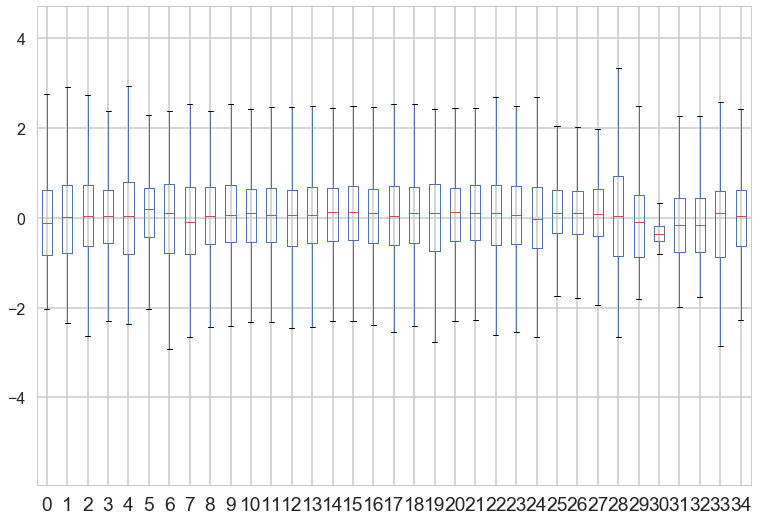

In [115]:
from sklearn import preprocessing
scalar = preprocessing.StandardScaler().fit(x_train)
scaled_x_train = pd.DataFrame(scalar.transform(x_train))
scaled_x_test = pd.DataFrame(scalar.transform(x_test))
scaled_x_train.boxplot()

In [116]:
#scaled_x_train.hist()
#Most features are normally distributed
#np.shape(scaled_x_train)

Use PCA to reduce multicollinearity in the data:

[  30.72   43.24   53.4    60.65   65.25   68.5    71.18   73.68   75.7
   77.57   79.22   80.65   82.06   83.41   84.69   85.95   87.09   88.18
   89.26   90.27   91.24   92.18   93.09   93.96   94.79   95.58   96.32
   97.05   97.64   98.15   98.59   99.01   99.42   99.75  100.  ]


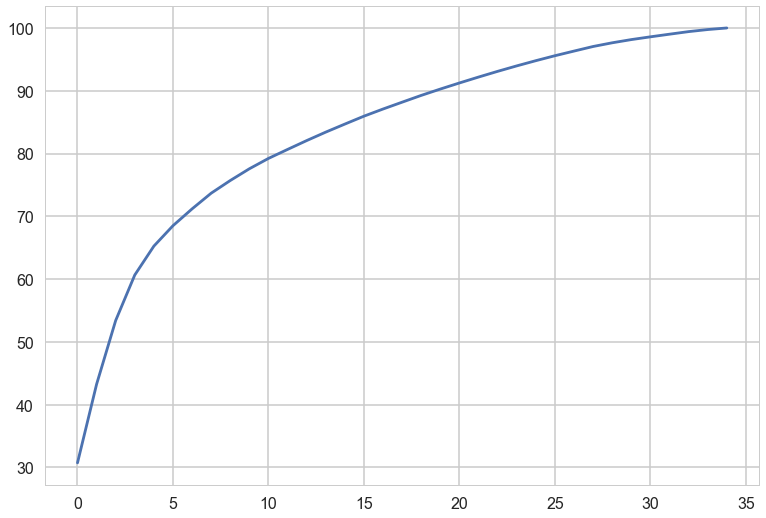

In [117]:
#run pca

pca = PCA(n_components=35)

pca.fit(scaled_x_train)

var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)

plt.plot(var1)
plt.show()

As 20% of the components explain more than 90% of the data, we use the 20% components

In [118]:
pca = PCA(n_components=20)
pca.fit(scaled_x_train)
X1=pca.fit_transform(scaled_x_train)

In [119]:
# fit linear regression on train
lm.fit(X1, y_train)
lm.predict(X1)
mse_train = np.mean((y_train - lm.predict(X1))**2)
mse_train

4.1773008597683239

In [120]:
print('R square:')
lm.score(X1, y_train)

R square:


0.89272575118091901

[  32.39   46.25   55.16   61.2    64.99   68.04   70.65   73.04   75.22
   77.07   78.8    80.44   82.01   83.4    84.76   86.07   87.34   88.52
   89.67   90.8    91.85   92.81   93.74   94.63   95.42   96.18   96.85
   97.46   98.06   98.58   99.02   99.39   99.69   99.88  100.  ]


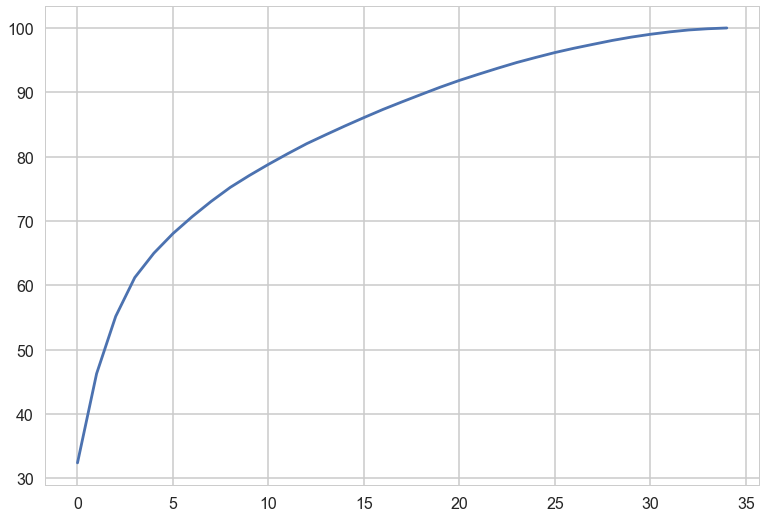

In [121]:
#PCA for test data:
#run pca

pca = PCA(n_components=35)

pca.fit(scaled_x_test)

var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)

plt.plot(var1)
plt.show()

In [122]:
pca = PCA(n_components=20)
pca.fit(scaled_x_test)
X2=pca.fit_transform(scaled_x_test)

In [123]:
y_pred = lm.predict(X2)
mse_test = np.mean((y_test - lm.predict(X2))**2)
mse_test

16.309626226823742

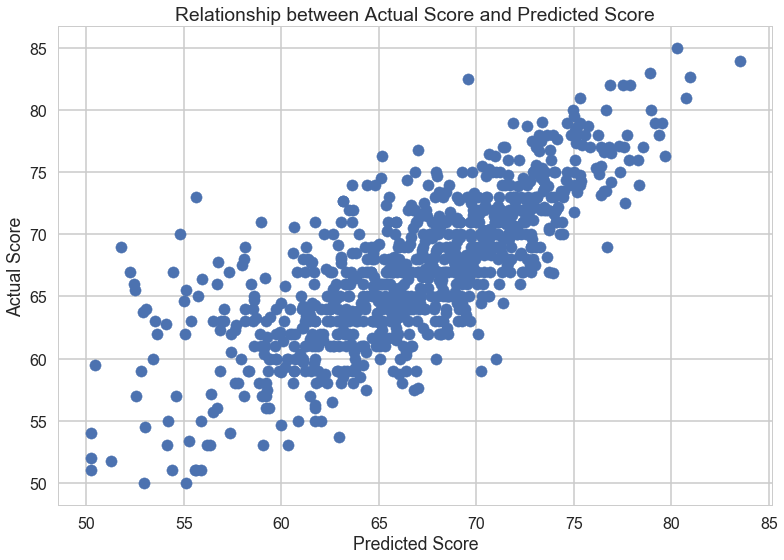

In [124]:
#plot predicted vs actual
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.title("Relationship between Actual Score and Predicted Score")

In [126]:
rss = sum((y_pred-y_test)**2)
print('RSS:')
print(rss)

RSS:
[ 14140.44593866]


In [128]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error:')
rms

Root mean squared error:


4.03851782549288

Linear regression score shows Rsquare to be 0.89, so the model is a good fit

**Fitting Ridge Regression with PCA**

In [106]:
#import modules to run ridge
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn import metrics

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [107]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

**Question below- Do we only scale x values not y?**

[  30.72   43.24   53.4    60.65   65.25   68.5    71.18   73.68   75.7
   77.57   79.22   80.65   82.06   83.41   84.69   85.95   87.09   88.18
   89.26   90.27   91.24   92.18   93.09   93.96   94.79   95.58   96.32
   97.05   97.64   98.15   98.59   99.01   99.42   99.75  100.  ]


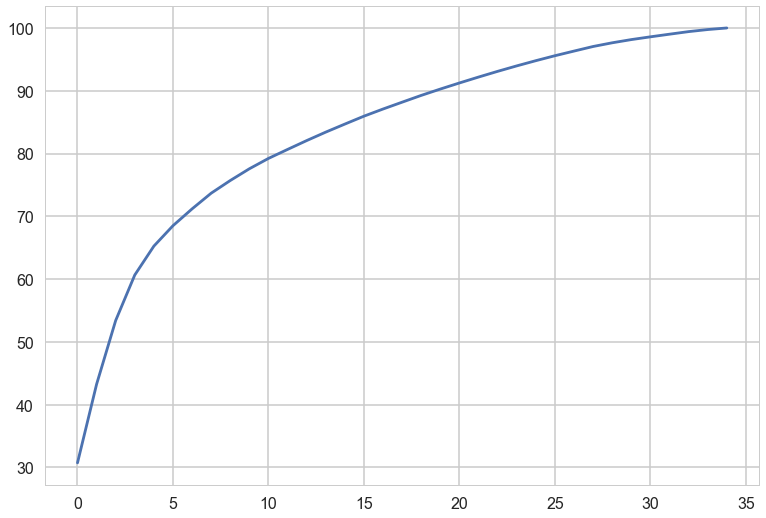

In [108]:
#Scaling the values
x_train_scale = scale(x_train)
#y_train = scale(y_train) 
x_test_scale = scale(x_test)
#y_test = scale(y_test)

#run pca

pca = PCA(n_components=35)

pca.fit(x_train_scale)

var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)

plt.plot(var1)
plt.show()


As 20 components explain more than 90% of the variance, we select number of components as 20.

In [109]:
pca = PCA(n_components=20)
pca.fit(x_train_scale)
X1=pca.fit_transform(x_train_scale)

#fit the ridge regression model with alpha at 0.01
clf = Ridge(alpha=0.01)
clf.fit(X1, y_train)
score = clf.score(X1, y_train)
print('Rsquare:')
print(score)

y_pred = clf.predict(X1)
rss = sum((y_pred-y_train)**2)
print('RSS:')
print(rss)

Rsquare:
0.892814360544
RSS:
[ 14378.91454805]


Testing data:

[ 30.48  42.75  51.09  56.46  60.32  63.81  66.74  69.49  72.15  74.6
  76.97  78.97  80.88  82.51  84.13  85.5   86.78  87.98  89.12  90.24
  91.32  92.32  93.22  94.1   94.91  95.64  96.36  97.04  97.63  98.2
  98.67  99.09  99.44  99.72  99.99]


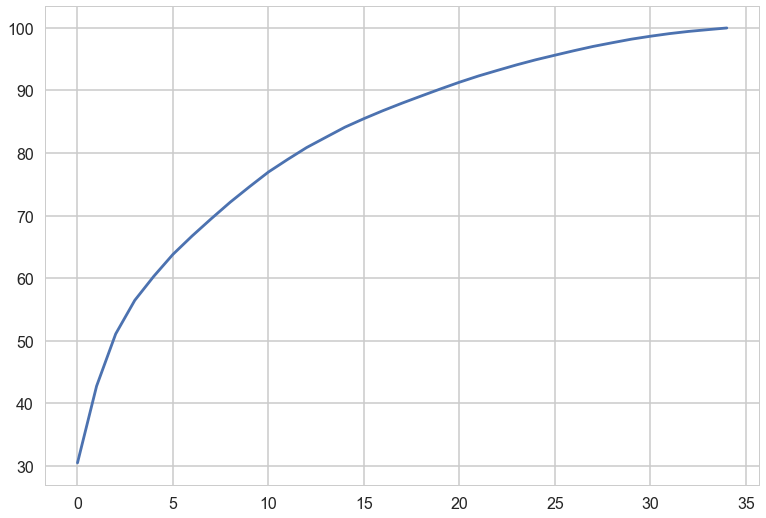

In [110]:
#run pca

pca = PCA(n_components=35)

pca.fit(x_test_scale)

var= pca.explained_variance_ratio_
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)

plt.plot(var1)
plt.show()

**How to fit the same Model on test data when PCA for test data has only 3 components?**
Also how to use ridgeCV to calculate best alpha (previous method gave error)

In [111]:
#PCA on x_test:
pca = PCA(n_components=20)
pca.fit(x_test_scale)
X2=pca.fit_transform(x_test_scale)

# predict method uses the best alpha value
y_pred = clf.predict(X2)

rss = sum((y_pred-y_test)**2)
print('RSS:')
print(rss)

#predicted scores for test
predicted_scores = clf.predict(X2)

RSS:
[ 7573.21585159]


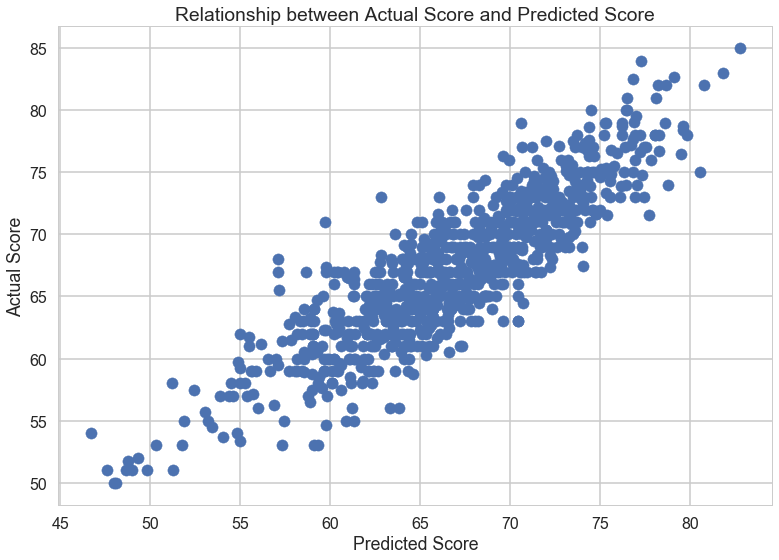

In [112]:
#plot predicted vs actual
plt.scatter(predicted_scores, y_test)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.title("Relationship between Actual Score and Predicted Score")

In [113]:
#calculate root mean square error for the predicted scores:
rms = sqrt(mean_squared_error(y_test, y_pred))
rms

2.9554976535510638

Fitting a SVR

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

Use the PCA components from above and fit a SVR model:

In [136]:
svr = SVR(kernel='linear')
lm = LinearRegression()
svr.fit(X1.reshape(-1,20),y_train.flatten())
lm.fit(X1.reshape(-1,20), y_train.flatten())

pred_SVR = svr.predict(X2.reshape(-1,20))
pred_lm = lm.predict(X2.reshape(-1,20))

In [140]:
'''
plt.plot(X1,y_train, label='True data')
plt.plot(X2[::20], pred_SVR[::20], 'co', label='SVR')
plt.plot(X2[1::20], pred_lm[1::20], 'mo', label='Linear Reg')
plt.legend(loc='upper left');
'''

"\nplt.plot(X1,y_train, label='True data')\nplt.plot(X2[::20], pred_SVR[::20], 'co', label='SVR')\nplt.plot(X2[1::20], pred_lm[1::20], 'mo', label='Linear Reg')\nplt.legend(loc='upper left');\n"

In [143]:
score_svr = svr.score(X1.reshape(-1,20), y_train.flatten())
score_svr

0.80788367674441286

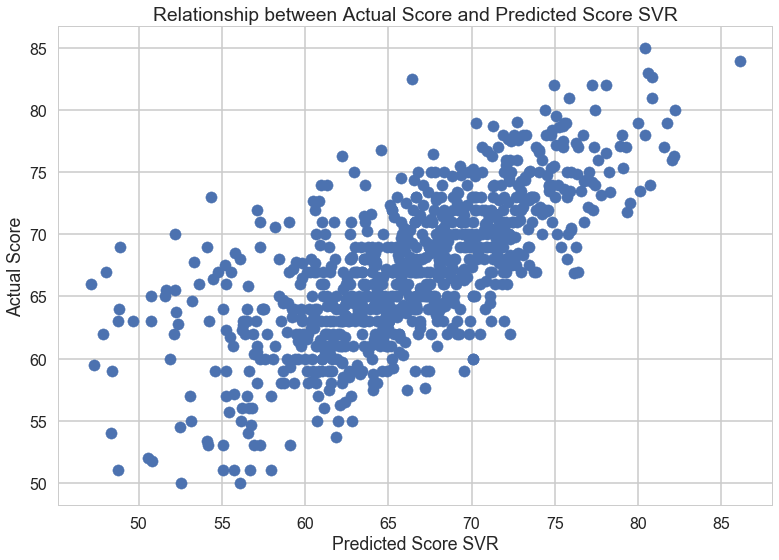

In [144]:
#plot predicted vs actual
plt.scatter(pred_SVR, y_test)
plt.xlabel("Predicted Score SVR")
plt.ylabel("Actual Score")
plt.title("Relationship between Actual Score and Predicted Score SVR")

In [145]:
#calculate root mean square error for the predicted scores:
rms = sqrt(mean_squared_error(y_test, pred_SVR))
rms

4.8993454606558755

According to this, the best fitting model with least RMS is Ridge regression with PCA